# 6장. 임베딩을 사용한 감성 프로그래밍

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch06/06-sentiment-analysis.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch06/06-sentiment-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

## Sarcasm 데이터셋 로딩 및 전처리

In [2]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [3]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## 텐서플로의 임베딩

### 임베딩을 사용해 빈정거림 감지기 만들기

In [8]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 6s 4ms/step - loss: 0.6822 - accuracy: 0.5590 - val_loss: 0.6631 - val_accuracy: 0.5756
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.5684 - accuracy: 0.7185 - val_loss: 0.4966 - val_accuracy: 0.7741
Epoch 3/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4062 - accuracy: 0.8256 - val_loss: 0.4387 - val_accuracy: 0.7919
Epoch 4/30
719/719 [==============================] - 3s 4ms/step - loss: 0.3385 - accuracy: 0.8564 - val_loss: 0.4245 - val_accuracy: 0.8010
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2987 - accuracy: 0.8739 - val_loss: 0.4222 - val_accuracy: 0.8072
Epoch 6/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2712 - accuracy: 0.8895 - val_loss: 0.4618 - val_accuracy: 0.7862
Epoch 7/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2472 - accuracy: 0.8985 - val_loss: 0.4421 - val_accuracy: 0.8021
Epoch 

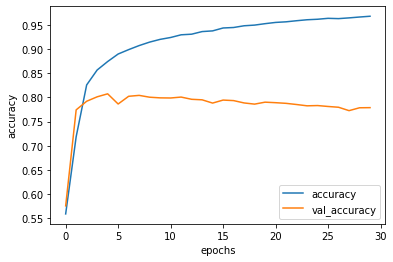

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

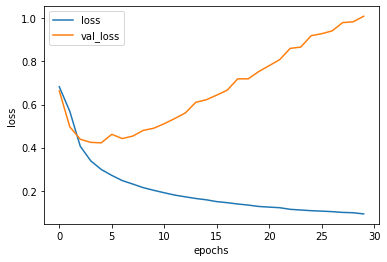

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### 언어 모델의 과대적합 줄이기

#### 학습률 조정하기

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, 
                               beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 4s 4ms/step - loss: 0.6876 - accuracy: 0.5596 - val_loss: 0.6830 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6848 - accuracy: 0.5596 - val_loss: 0.6820 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6837 - accuracy: 0.5596 - val_loss: 0.6805 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6821 - accuracy: 0.5596 - val_loss: 0.6787 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6796 - accuracy: 0.5596 - val_loss: 0.6759 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6759 - accuracy: 0.5596 - val_loss: 0.6718 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6704 - accuracy: 0.5598 - val_loss: 0.6666 - val_accuracy: 0.5713

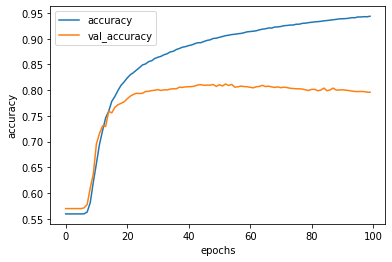

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

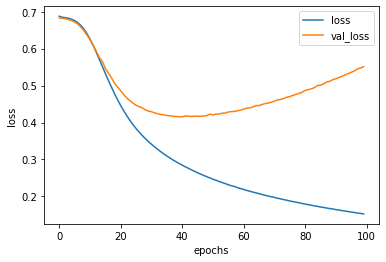

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 어휘 사전 크기 바꾸기

In [ ]:
wc=tokenizer.word_counts
# 출력이 길어 노트북에서 제외함
print(wc)

In [ ]:
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
# 출력이 길어 노트북에서 제외함
print(newlist)

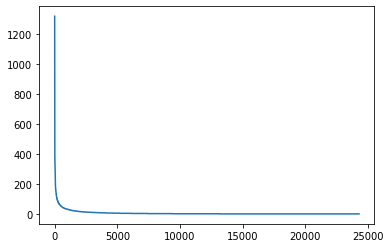

In [19]:
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.show()

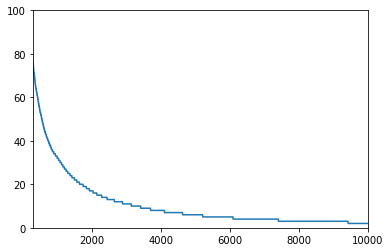

In [20]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [21]:
vocab_size = 2000

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [25]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 4s 4ms/step - loss: 0.6825 - accuracy: 0.5581 - val_loss: 0.6631 - val_accuracy: 0.5716
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.5755 - accuracy: 0.6999 - val_loss: 0.5162 - val_accuracy: 0.7412
Epoch 3/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4658 - accuracy: 0.7781 - val_loss: 0.4768 - val_accuracy: 0.7611
Epoch 4/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4322 - accuracy: 0.7931 - val_loss: 0.4634 - val_accuracy: 0.7727
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4182 - accuracy: 0.8007 - val_loss: 0.4610 - val_accuracy: 0.7733
Epoch 6/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4098 - accuracy: 0.8040 - val_loss: 0.4709 - val_accuracy: 0.7657
Epoch 7/30
719/719 [==============================] - 3s 4ms/step - loss: 0.4051 - accuracy: 0.8071 - val_loss: 0.4677 - val_accuracy: 0.7773
Epoch 

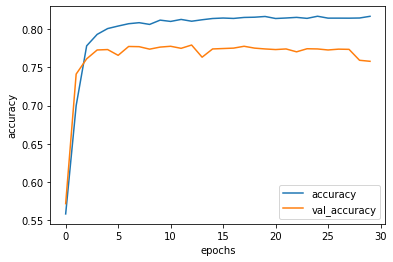

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

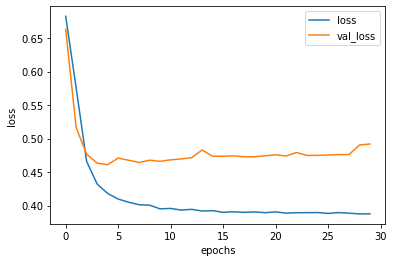

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 임베딩 차원 바꾸기

In [28]:
embedding_dim = 7

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [30]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6825 - accuracy: 0.5597 - val_loss: 0.6685 - val_accuracy: 0.5694
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6120 - accuracy: 0.6657 - val_loss: 0.5504 - val_accuracy: 0.7301
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4963 - accuracy: 0.7582 - val_loss: 0.4870 - val_accuracy: 0.7584
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4478 - accuracy: 0.7861 - val_loss: 0.4746 - val_accuracy: 0.7617
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4262 - accuracy: 0.7949 - val_loss: 0.4704 - val_accuracy: 0.7654
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4150 - accuracy: 0.8012 - val_loss: 0.4622 - val_accuracy: 0.7765
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4093 - accuracy: 0.8052 - val_loss: 0.4734 - val_accuracy: 0.7660

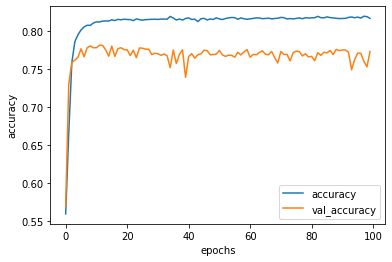

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

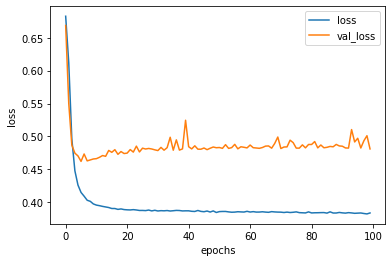

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 모델 구조 변경하기

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [34]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 4s 4ms/step - loss: 0.6846 - accuracy: 0.5584 - val_loss: 0.6791 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6667 - accuracy: 0.5762 - val_loss: 0.6375 - val_accuracy: 0.6727
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.5890 - accuracy: 0.7009 - val_loss: 0.5622 - val_accuracy: 0.7231
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.5120 - accuracy: 0.7585 - val_loss: 0.5025 - val_accuracy: 0.7565
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4667 - accuracy: 0.7800 - val_loss: 0.4849 - val_accuracy: 0.7590
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4422 - accuracy: 0.7913 - val_loss: 0.4803 - val_accuracy: 0.7576
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4289 - accuracy: 0.7953 - val_loss: 0.4720 - val_accuracy: 0.7622

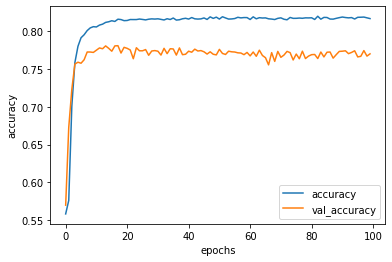

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

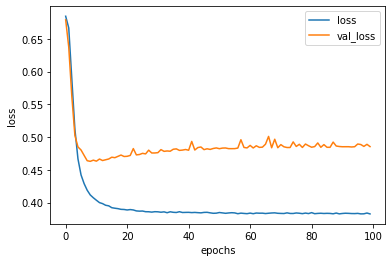

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 드롭아웃 사용하기

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [38]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 4s 4ms/step - loss: 0.6855 - accuracy: 0.5596 - val_loss: 0.6777 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6525 - accuracy: 0.6224 - val_loss: 0.6168 - val_accuracy: 0.7034
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.5805 - accuracy: 0.7042 - val_loss: 0.5457 - val_accuracy: 0.7390
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.5236 - accuracy: 0.7437 - val_loss: 0.5061 - val_accuracy: 0.7573
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4874 - accuracy: 0.7635 - val_loss: 0.4811 - val_accuracy: 0.7657
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4693 - accuracy: 0.7710 - val_loss: 0.4736 - val_accuracy: 0.7687
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4567 - accuracy: 0.7782 - val_loss: 0.4681 - val_accuracy: 0.7733

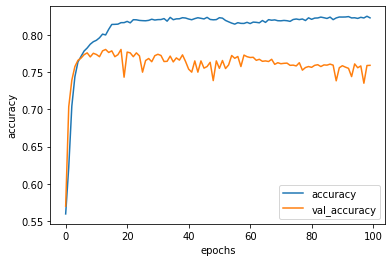

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

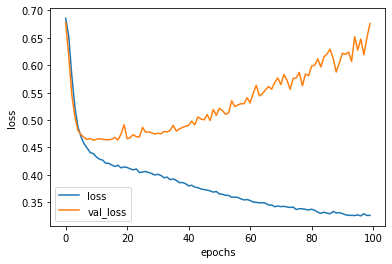

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 규제 사용하기

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [42]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 4s 4ms/step - loss: 0.7085 - accuracy: 0.5600 - val_loss: 0.6847 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6860 - accuracy: 0.5596 - val_loss: 0.6829 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6852 - accuracy: 0.5596 - val_loss: 0.6822 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6828 - accuracy: 0.5596 - val_loss: 0.6785 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6737 - accuracy: 0.5614 - val_loss: 0.6644 - val_accuracy: 0.5923
Epoch 6/100
719/719 [==============================] - 4s 6ms/step - loss: 0.6542 - accuracy: 0.6207 - val_loss: 0.6437 - val_accuracy: 0.6576
Epoch 7/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6298 - accuracy: 0.6812 - val_loss: 0.6218 - val_accuracy: 0.6856

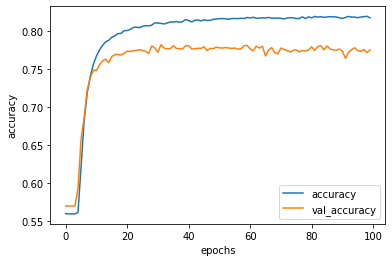

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

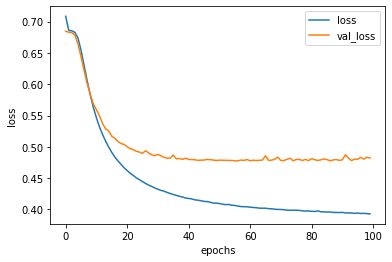

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 다른 고려 사항

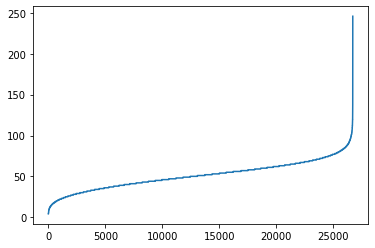

In [45]:
xs=[]
ys=[]
current_item=1
for item in sentences:
    xs.append(current_item)
    current_item=current_item+1
    ys.append(len(item))
newys = sorted(ys)

plt.plot(xs,newys)
plt.show()

### 모델을 사용해 문장 분류하기

In [46]:
sentences = ["granny starting to fear spiders in the garden might be real", 
             "game of thrones season finale showing this sunday night", 
             "TensorFlow book will be a best seller"]

In [47]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 803, 1, 753, 1, 1, 1, 1, 312, 1, 97], [123, 1, 1183, 160, 1, 1, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1]]


In [48]:
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
print(padded)

[[   1  803    1  753    1    1    1    1  312    1   97    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 123    1 1183  160    1    1    1 1543  152    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [49]:
print(model.predict(padded))

1/1 [==============================] - 0s 171ms/step
[[0.73394644]
 [0.03061298]
 [0.15492353]]


## 임베딩 시각화

In [50]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(2000, 7)


In [51]:
print(tokenizer.index_word[2])
print(weights[2])

new
[ 0.6022285 -0.8475791  0.8939301  0.7452286  0.8627297 -0.8690545
 -0.8533438]


In [52]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = tokenizer.index_word[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

## 텐서플로 허브에서 사전 훈련된 임베딩 사용하기

In [53]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", 
    output_shape=[20], input_shape=[], 
    dtype=tf.string, trainable=False
)

In [54]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, 
                                beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',optimizer=adam, 
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_14 (Dense)            (None, 16)                336       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [56]:
# 넘파이 배열로 바뀐 레이블을 다시 리스트로 변경합니다.
training_labels = training_labels.tolist()
testing_labels = testing_labels.tolist()

In [57]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs,
                    validation_data=(testing_sentences, testing_labels))

Epoch 1/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6834 - accuracy: 0.5500 - val_loss: 0.6735 - val_accuracy: 0.5748
Epoch 2/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6694 - accuracy: 0.5862 - val_loss: 0.6648 - val_accuracy: 0.5967
Epoch 3/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6624 - accuracy: 0.6064 - val_loss: 0.6598 - val_accuracy: 0.6085
Epoch 4/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6577 - accuracy: 0.6156 - val_loss: 0.6557 - val_accuracy: 0.6120
Epoch 5/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6540 - accuracy: 0.6212 - val_loss: 0.6521 - val_accuracy: 0.6169
Epoch 6/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6509 - accuracy: 0.6259 - val_loss: 0.6490 - val_accuracy: 0.6223
Epoch 7/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6482 - accuracy: 0.6294 - val_loss: 0.6462 - val_accuracy: 0.6239
Epoch 

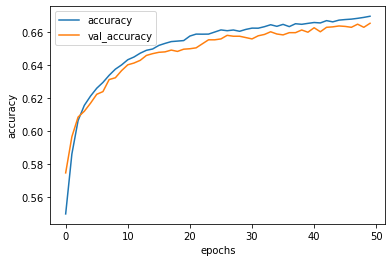

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

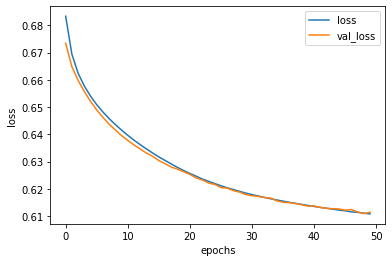

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()